In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive




In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

train_data_dir = '/content/drive/MyDrive/dataset3/Training'
test_data_dir = '/content/drive/MyDrive/dataset3/Testing'



Mounted at /content/drive


In [ ]:
# Image dimensions and other parameters
image_height = 150
image_width = 150
num_channels = 3
batch_size = 32
num_classes = 4
epochs = 10

# Data augmentation for training set
train_data_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data augmentation for testing/validation set
test_data_generator = ImageDataGenerator(rescale=1.0 / 255)

# Load training dataset
train_generator = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load testing/validation dataset
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 5714 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Load pre-trained VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, num_channels))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture by adding custom top layers to the base model
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, steps_per_epoch=10, epochs=10)

# Evaluate the model on the testing/validation dataset
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
10/10 [==============================] - 84s 7s/step - loss: 1.7677 - accuracy: 0.4250
Epoch 2/10
10/10 [==============================] - 75s 7s/step - loss: 0.9425 - accuracy: 0.6094
Epoch 3/10
10/10 [==============================] - 71s 7s/step - loss: 0.7466 - accuracy: 0.7219
Epoch 4/10
10/10 [==============================] - 67s 6s/step - loss: 0.6816 - accuracy: 0.7375
Epoch 5/10
10/10 [==============================] - 65s 6s/step - loss: 0.6764 - accuracy: 0.7406
Epoch 6/10
10/10 [==============================] - 66s 6s/step - loss: 0.6037 - accuracy: 0.7469
Epoch 7/10
10/10 [==============================] - 61s 6s/step - loss: 0.6240 - accuracy: 0.7688
Epoch 8/10
10/10 [==============================] - 63s 6s/step - loss: 0.6019 - accuracy: 0.7750
Epoch 9/10
10/10 [==============================] - 62s 6s/step - loss: 0.6168 - accuracy: 0.7781
Epoch 10/10
41/41 [==============================] - 

In [ ]:
from tensorflow.keras.models import load_model

model.save('vgg16_75.h5')

In [ ]:
import cv2
import numpy as np
import os
true_value = []
pred = []
i=0
for folder in os.listdir(test_data_dir):
    i=0
    test_image_ids = os.listdir(os.path.join(test_data_dir,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:

        path = os.path.join(test_data_dir,folder,image_id)

        true_value.append(test_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255

        p = np.argmax(model.predict(np.array([img_normalized])))
        pred.append(p)

1/1 [==============================] - 0s 192ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.7581998474446987
              precision    recall  f1-score   support

      glioma       0.88      0.56      0.68       300
  meningioma       0.55      0.55      0.55       306
     notumor       0.81      0.95      0.87       405
   pituitary       0.80      0.92      0.85       300

    accuracy                           0.76      1311
   macro avg       0.76      0.74      0.74      1311
weighted avg       0.76      0.76      0.75      1311



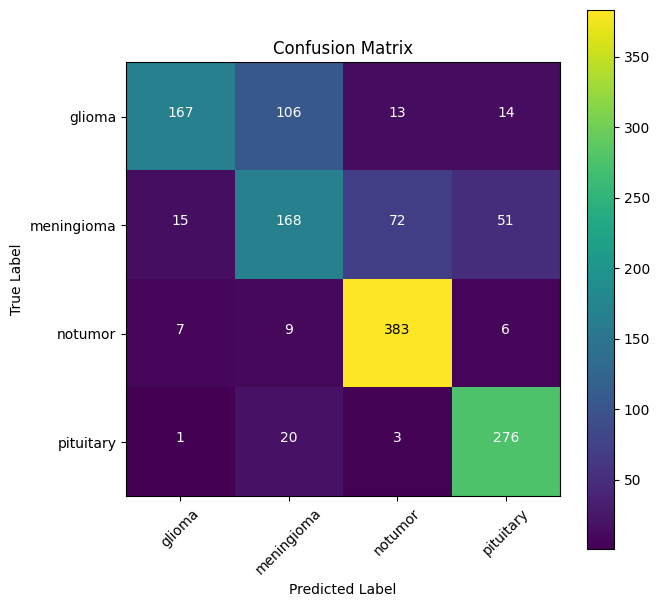

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
clf_report(true_value, pred)